# 策略交易逻辑
---

### 布林轨道突破
1. 最新一期收盘价 **上穿** 布林带上轨做多（空仓）或平空（已开空）
2. 最新一期收盘价 **下穿** 布林带下轨做空（空仓）或平多（已开多）
3. 当最新的价格较开仓价亏损4%时，止损出场
4. 当最近400期最大回撤超过4%则出场
4. 每次交易全仓进入 
5. 策略为两个参数，布林带均线周期及上下轨距标准差

In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
from wlkbacktest import Strategy
from talib.abstract import BBANDS

### 定义布林带指标及交易信号

In [2]:
# BOLL
def BOLL(data, timeperiod=25, nbdevup=2, nbdevdn=2, matype=0):
    df = data.join(BBANDS(data, timeperiod, nbdevup, nbdevdn, matype))
    buy = (df.close.shift(1) < df.upperband.shift(1)) & (df.close > df.upperband) #突破上轨 做多
    sell = (df.close.shift(1) > df.lowerband.shift(1)) & (df.close < df.lowerband) #下穿下轨 做空
    df['signal'] = np.where(buy, 1, np.where(sell, -1, np.nan))
    df.signal = df.signal.shift(1) # 信号下一根bar触发
    return df

In [3]:
# 最大回撤
def max_dn(pl):
    return np.max(1 - pl / pd.expanding_max(pl))
# 最大涨幅
def max_up(pl):
    return np.max(pl / pd.expanding_min(pl) - 1)

### 用户自定义策略环境信息

In [4]:
STK = 'zz500'
# 初始化策略变量
def init(context,**kwargs):
    context.start = '20130101'
    context.end = '20151231'
    context.cash = 10000000
    context.minute = 1
    context._slippage = 0.1  # 交易滑点
    context.commision = 0.015 #万1.5
    context.securities = [STK]

    context.long_short = None # 持仓方向
    context.cost = None #记录开仓成本价
    context.holding_times = 0

### 初始化交易策略

In [5]:
strategy = Strategy(init) 

### 获取交易数据

In [6]:
datas = strategy.get_trading_data() #pandas.Panel
datas 

<class 'pandas.core.panel.Panel'>
Dimensions: 1 (items) x 174480 (major_axis) x 6 (minor_axis)
Items axis: zz500 to zz500
Major_axis axis: 2013-01-04 09:31:00 to 2015-12-31 15:00:00
Minor_axis axis: open to amount

### 中证500数据

In [7]:
dfs = datas[STK] #获取中证500数据
dfs.head()

,open,high,low,close,volume,amount
date_time,,,,,,
2013-01-04 09:31:00,3297.0400,3304.6900,3297.0400,3304.2100,1020089.0000,825728896.0000
2013-01-04 09:32:00,3304.0500,3304.0500,3299.9900,3299.9900,492730.0000,408369536.0000
2013-01-04 09:33:00,3299.3300,3299.3300,3295.0500,3295.0500,434598.0000,344187136.0000
2013-01-04 09:34:00,3294.5100,3294.5100,3291.8400,3291.8400,440774.0000,351569920.0000
2013-01-04 09:35:00,3291.8200,3291.8200,3290.7300,3291.0900,371529.0000,285684736.0000


### 定义全局变量数据，包含开平仓点位，方便algo函数中查找交易信号 ，优化执行效率

In [8]:
DF = BOLL(dfs,timeperiod=6000,nbdevup=1.2, nbdevdn=1.2) #1分钟线一天240根bar,6000期约25天，上下规矩标准差为1.2

In [9]:
DF[np.abs(DF.signal)==1].head() # 下单点位
max_up_ts = pd.rolling_apply(dfs.close,window=400,func=max_up)   # 中证500，最近400根bar最大回测
max_dd_ts = pd.rolling_apply(dfs.close,window=400,func=max_dn)    # 中证500,最近400根bar最大涨幅

### 策略算法逻辑，algo函数用户实现

In [10]:
# 策略交易逻辑
def algo(data,broker,context,**kwargs):
    stk = STK
    now = broker.now # 获取当前回测日期(日期或每天分钟)
    signal = DF.at[now,'signal'] #获取当期信交易信号值
    ex_price = DF.at[now,'open'] #获取当期信开盘价
    
    # 空仓 非最后一个交易日
    if context.holding_times==0 and now < context.end:
        if signal == 1: #有做多信号
            broker.order_percent(stk,ex_price,1,'long') #全仓做多
            context.cost = ex_price
            print(now,stk,'long open')
            context.long_short = 'long' 
            context.holding_times = 1
        elif signal == -1:
            broker.order_percent(stk,ex_price,1,'short') #全仓做空
            context.cost = ex_price
            context.long_short = 'short'
            context.holding_times = 1
            print(now,stk,'short open')
    # 持有
    elif context.holding_times!=0:
        if now >= context.end: #最后一个交易日
            broker.order_percent(stk,ex_price,-1,context.long_short) #平仓
            print(now,stk,'last day out')
            context.long_short = None
            context.holding_times = 0
            return
        else:
 
            # 价格止损和最近N天走势止损
            price = DF.at[now,'close']
            if context.long_short =='long':
                if (price/context.cost < 0.96): #当最新的价格较开仓价亏损4%时，止损出场
                    broker.order_percent(stk,price,-1,'long')
                    print('long stop loss 1:',now)
                    context.holding_times = 0
                    context.long_short = None
                    context.cost = None
                    return
            elif context.long_short =='short':
                if (context.cost/price < 0.96): #当最新的价格较开仓价亏损4%时，止损出场
                    broker.order_percent(stk,price,-1,'short')
                    print('short stop loss 1:',now)
                    context.holding_times = 0
                    context.long_short = None
                    context.cost = None
                    return
            
            if context.long_short =='long' and signal==-1:
                broker.order_percent(stk,ex_price,-1,'long')
                context.long_short = None
                context.holding_times = 0
                print(now,stk,'long exit')
                return
            elif context.long_short =='short' and signal==1:
                broker.order_percent(stk,ex_price,-1,'short')
                context.long_short = None
                context.holding_times = 0
                print(now,stk,'short exit')
                return
            
            if context.holding_times > 400:
                if context.long_short=='long':
                    max_dd = max_dd_ts.at[now]
                    if max_dd > 0.05: #持有超过400期，且最近400期最大回撤超过5%，止损
                        broker.order_percent(stk,price,-1,'long')
                        print('long stop loss 2:',now)
                        context.holding_times = 0
                        context.long_short = None
                        context.cost = None
                        return
                elif context.long_short=='short':
                    max_up = max_up_ts.at[now]
                    if max_up > 0.05: #持有超过400期，且最近400期最大回撤超过5%，止损
                        broker.order_percent(stk,price,-1,'short')
                        print('short stop loss 2:',now)
                        context.holding_times = 0
                        context.long_short = None
                        context.cost = None
                        return
        context.holding_times += 1 #持有期数加1

In [11]:
strategy.run_backtest(algo) #执行回测

2013-02-19 14:48:00 zz500 long open
2013-03-12 11:23:00 zz500 long exit
2013-03-15 14:33:00 zz500 short open
short stop loss 2: 2013-03-21 09:59:00
2013-03-28 09:34:00 zz500 short open
2013-05-06 13:45:00 zz500 short exit
2013-05-06 13:53:00 zz500 long open
long stop loss 2: 2013-06-13 09:32:00
2013-06-13 09:33:00 zz500 short open
short stop loss 2: 2013-06-25 13:54:00
2013-07-02 09:49:00 zz500 short open
short stop loss 2: 2013-07-11 09:42:00
2013-07-23 10:55:00 zz500 long open
long stop loss 1: 2013-07-30 10:11:00
2013-08-02 09:32:00 zz500 long open
2013-10-25 11:21:00 zz500 long exit
2013-10-25 13:07:00 zz500 short open
short stop loss 2: 2013-11-15 11:05:00
2013-11-27 11:07:00 zz500 long open
long stop loss 2: 2013-12-02 11:07:00
2013-12-04 09:50:00 zz500 long open
2013-12-19 14:30:00 zz500 long exit
2013-12-19 14:49:00 zz500 short open
2014-01-23 13:36:00 zz500 short exit
2014-01-24 09:34:00 zz500 long open
long stop loss 2: 2014-02-26 09:32:00
2014-03-10 13:12:00 zz500 short open

### 回测结果分析

In [12]:
strategy.backtest_analysis()

,value
Performance Statistics,
起始日,2013-01-04
结束日,2015-12-31
初始资金,10000000
结束资金,27359547.5386
总盈亏,17359547.5386
累计收益,1.7360
年化收益,0.4007
年化波动率,0.2370
交易时长,2 年 11 月 27 日


### 策略净值曲线

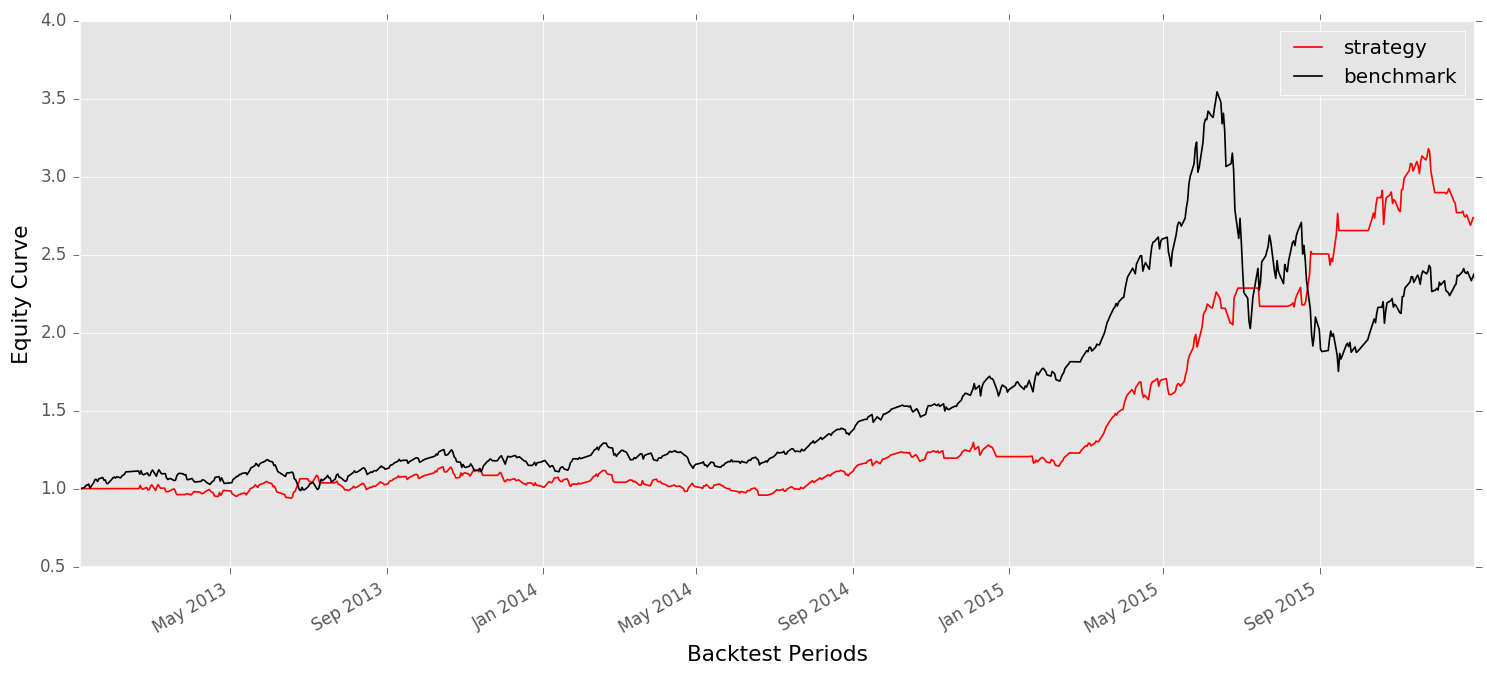

In [13]:
strategy.show_equity_curve()

### 策略持仓及下单点位

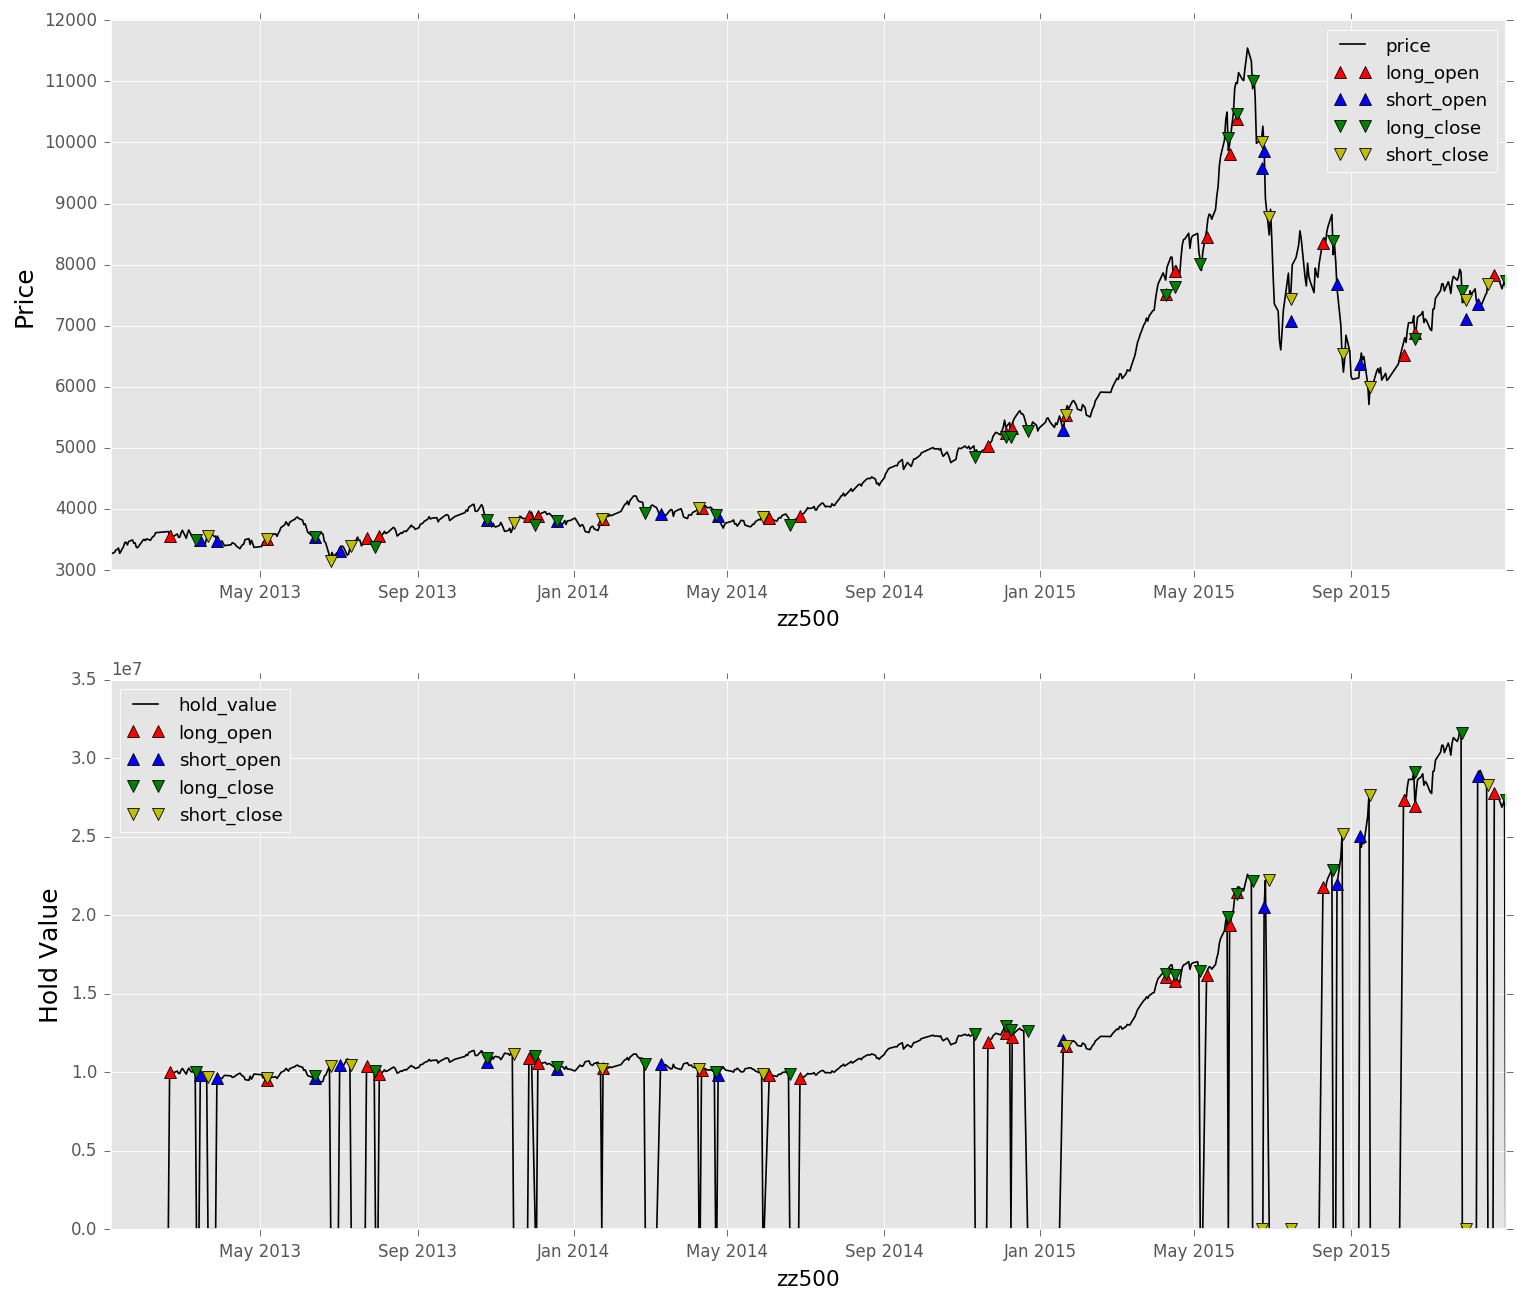

In [14]:
strategy.show_trade_information()